In [1]:
library(Seurat)
library(ggplot2)
library(cowplot)
library(dplyr)
library(tidyr)
library(future)
library(stringr)
library(ggpubr)
library(tibble)
library(rstatix)
library(patchwork)
library(ggrepel)
library(circlize)
library(ggcorrplot)
library(scales)
library(tidydr)
library(harmony)
library(UCell)
library(reshape2)
library(clusterProfiler)
library(org.Mm.eg.db)
library(AnnotationDbi)
library(ComplexHeatmap)
library(RColorBrewer)
library(randomcoloR)
options(jupyter.plot_scale=1, future.globals.maxSize=100*1024*1024*1024)
`%nin%` = Negate(`%in%`)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend



Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter



Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots


circlize version 0.4.16
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  

In [2]:
update_geom_defaults("point", aes(stroke = 0.1))

In [3]:
seu <- readRDS('data/b16_5batch.rds')

In [4]:
mac <- seu %>% subset(type == 'Macro/Mono')
mac

An object of class Seurat 
32285 features across 34428 samples within 1 assay 
Active assay: RNA (32285 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 3 dimensional reductions calculated: pca, harmony, umap

In [5]:
mac <- mac %>% FindVariableFeatures(verbose = FALSE) %>% ScaleData() %>% 
    RunPCA(verbose = FALSE, npcs = 50) %>% RunHarmony('batch')

Centering and scaling data matrix

Warning message:
“Different features in new layer data than already exists for scale.data”
Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony converged after 3 iterations



Warning message in ElbowPlot(mac, 100):
“The object only has information for 50 reductions”


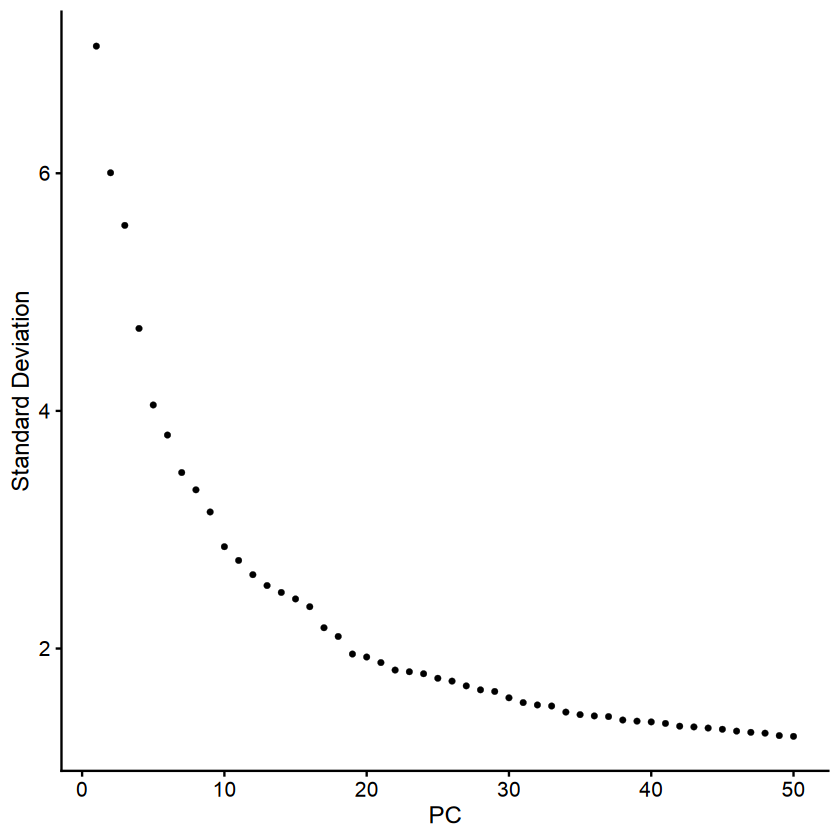

In [6]:
ElbowPlot(mac, 100)

In [7]:
mac <- mac %>% 
    FindNeighbors(dims = 1:40, verbose=FALSE, k.param=10, reduction='harmony') %>% 
    FindClusters(resolution = 1, verbose=FALSE) %>% 
    RunUMAP(dims = 1:40, verbose=FALSE, min.dist=0.3, reduction='harmony') 

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


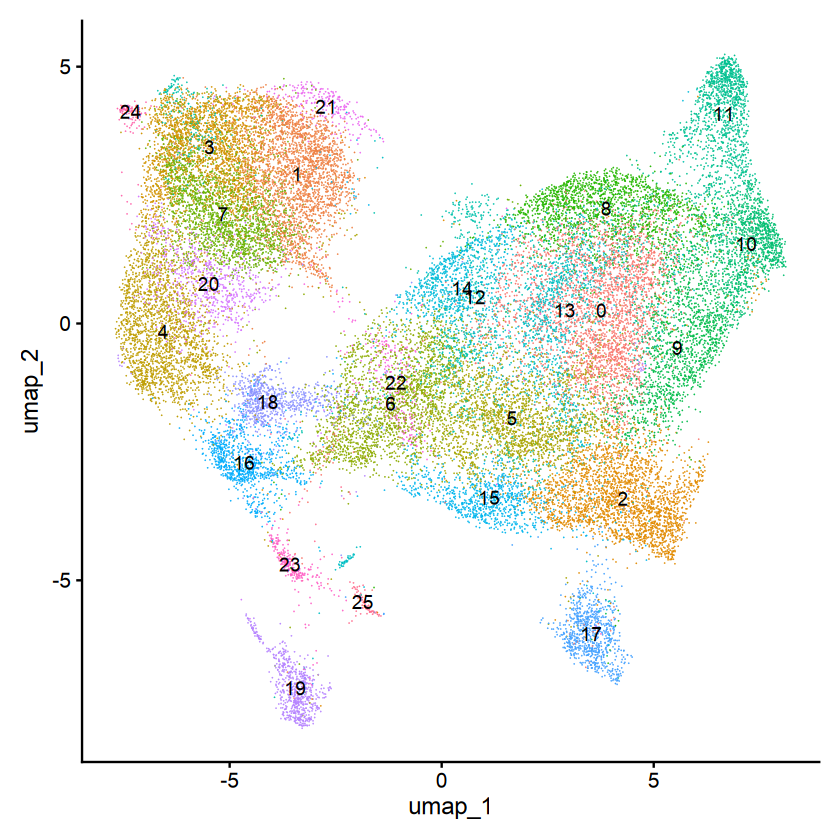

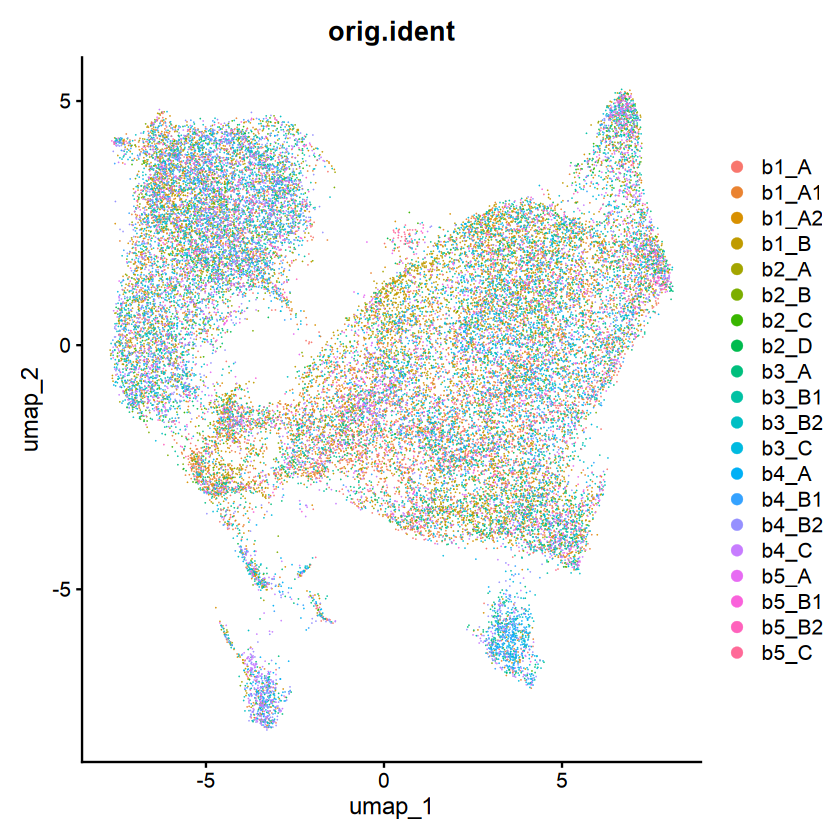

In [8]:
DimPlot(mac, label=TRUE) + NoLegend()
DimPlot(mac, group.by='orig.ident', label=F) 

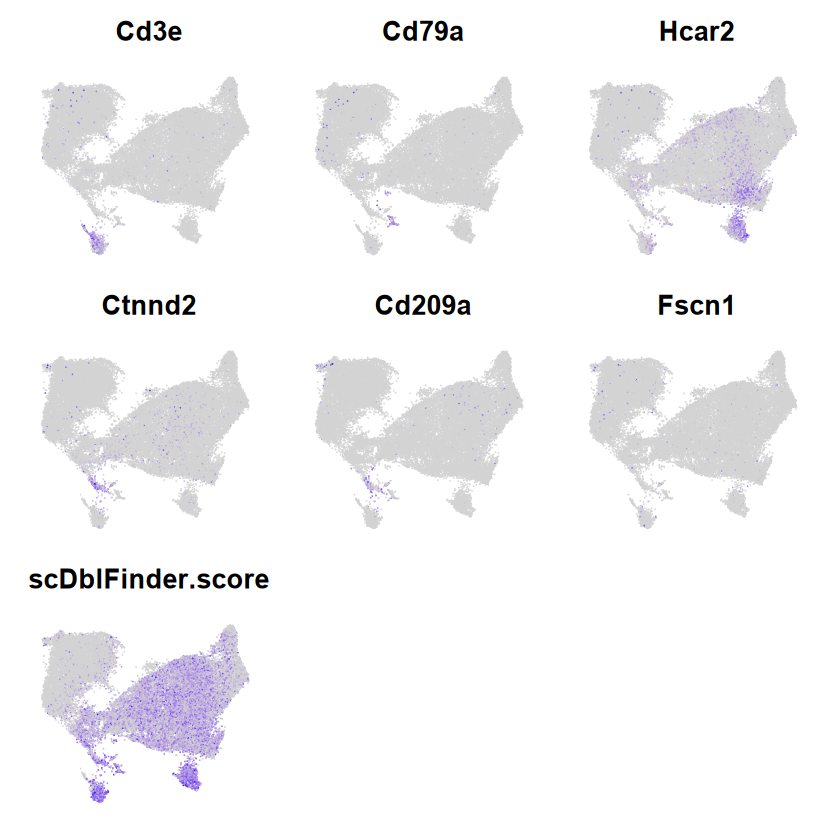

In [9]:
FeaturePlot(mac, c('Cd3e','Cd79a','Hcar2','Ctnnd2','Cd209a','Fscn1','scDblFinder.score')) & NoLegend() & NoAxes()

In [10]:
# cluster 17: neutrophil-macrophage doublets
# cluster 19: T-macrophage doublets
# cluster 23: DC-macrophage doublets
# cluster 25: B-macrophage doublets
mac <- subset(mac, seurat_clusters %nin% c(17,19,23,25))
mac

An object of class Seurat 
32285 features across 32552 samples within 1 assay 
Active assay: RNA (32285 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 3 dimensional reductions calculated: pca, harmony, umap

In [11]:
mac <- mac %>% FindVariableFeatures(verbose = FALSE) %>% ScaleData(verbose = FALSE) %>% 
    RunPCA(npcs = 50, verbose = FALSE) %>% RunHarmony('batch')

Warning message:
“Different features in new layer data than already exists for scale.data”
Transposing data matrix

Initializing state using k-means centroids initialization

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 1627600)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 1627600)”
Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony converged after 3 iterations



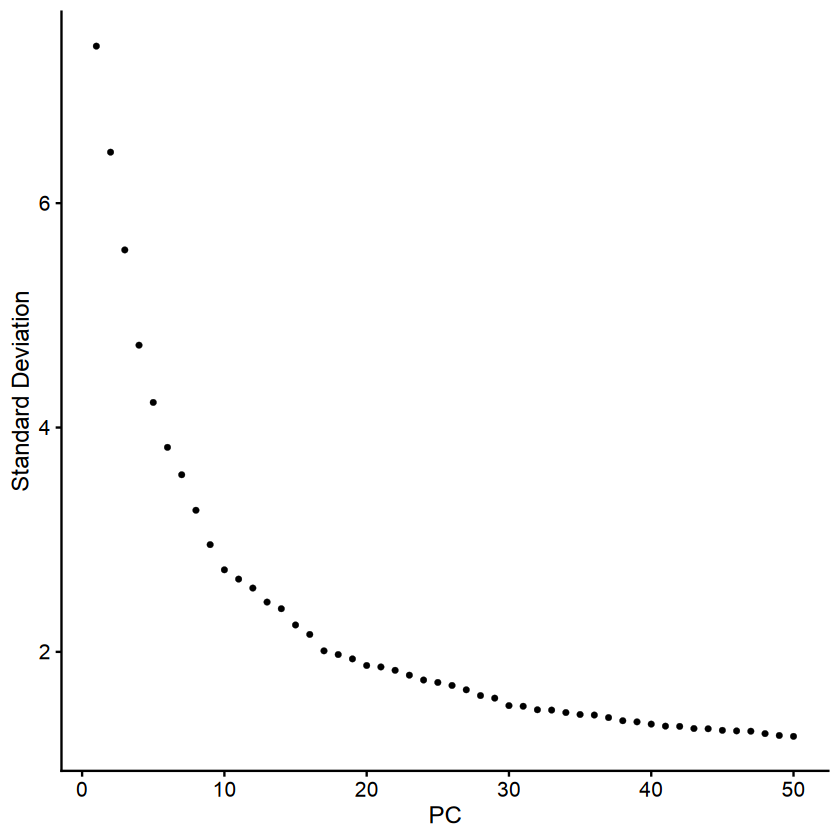

In [12]:
ElbowPlot(mac, 50)

In [13]:
mac <- mac %>%  
    FindNeighbors(dims = 1:40, verbose=FALSE, k.param=15, reduction='harmony') %>% #
    FindClusters(resolution = 0.3, verbose=FALSE) %>% 
    RunUMAP(dims = 1:40, verbose=FALSE, min.dist=0.3, reduction='harmony') #

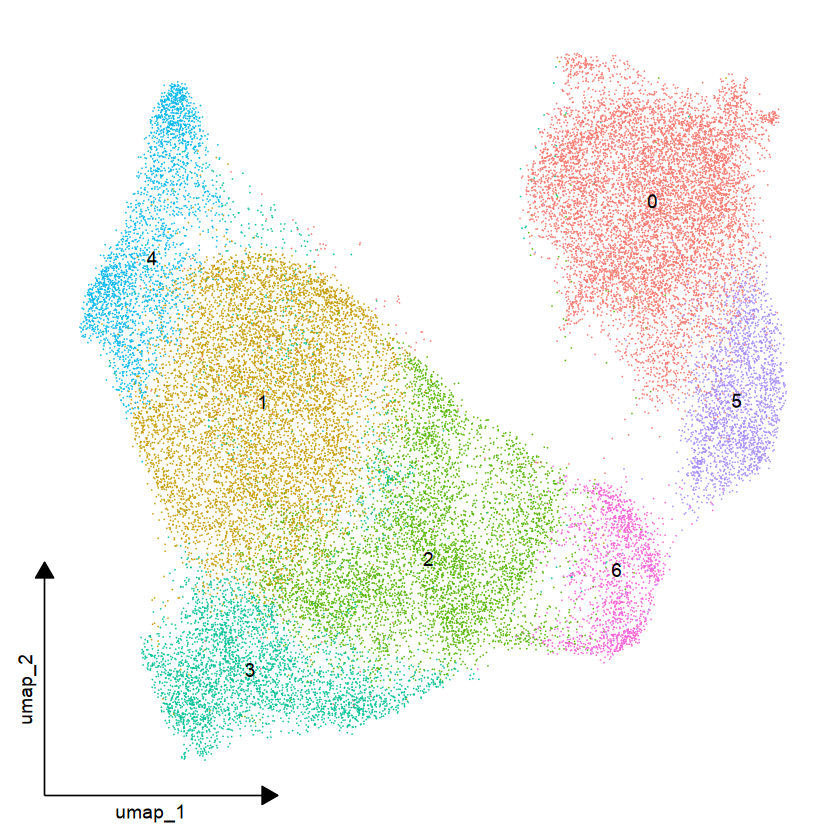

In [14]:
DimPlot(mac, label=TRUE) + theme_dr() + theme(panel.grid=element_blank(), legend.position='none') 

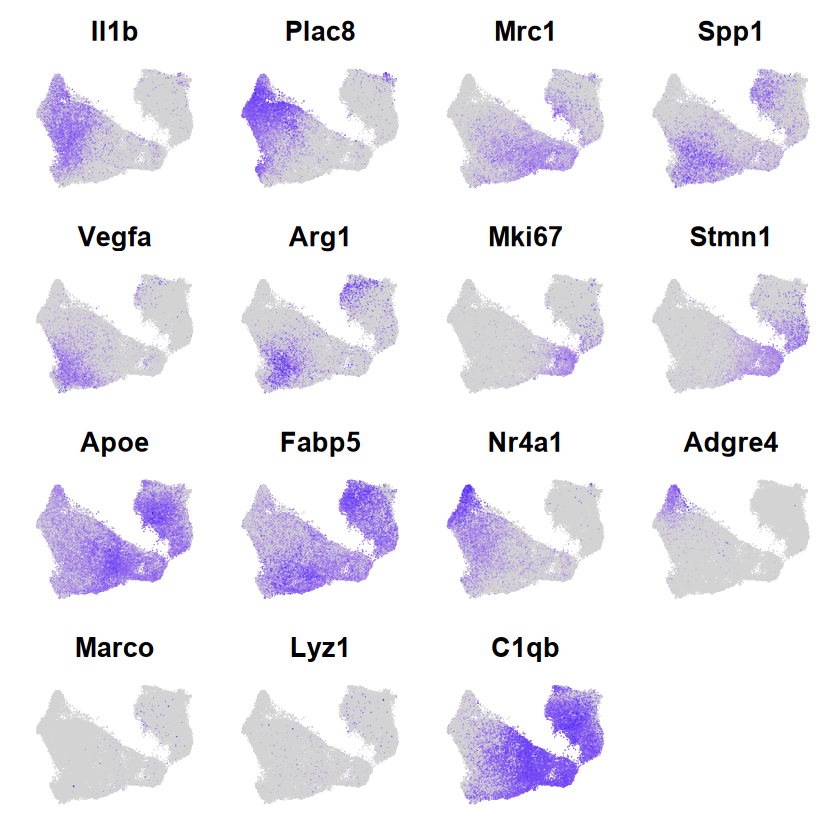

In [15]:
FeaturePlot(mac, c('Il1b','Plac8','Mrc1','Spp1','Vegfa','Arg1','Mki67','Stmn1','Apoe','Fabp5','Nr4a1','Adgre4','Marco','Lyz1','C1qb'), pt.size=0) &
    NoLegend() & NoAxes()

In [16]:
markers_mac <- FindAllMarkers(mac, assay='RNA', only.pos=F, logfc.threshold=0.25)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6



In [17]:
mac$annotation <- recode(mac$seurat_clusters,
                   '0'='Naive-TAM','1'='Inflam-TAM/Mono','2'='Reg-TAM','3'='Angio-TAM','4'='NC-Mono','5'='Naive-TAM','6'='Prolif-TAM')
Idents(mac) <- 'annotation'

mac <- readRDS('data/b16_mac.rds')

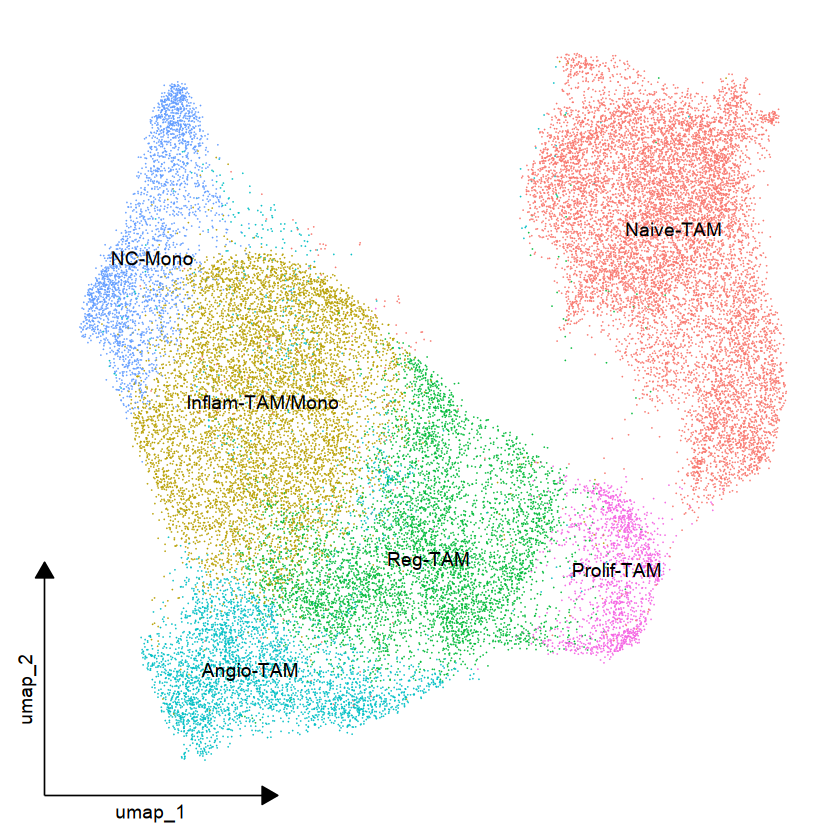

In [18]:
DimPlot(mac, label=TRUE) + theme_dr() + theme(panel.grid=element_blank(), legend.position='none') 
ggsave('plot/b16_umap_mac.pdf', width=4, height=4, device=pdf)

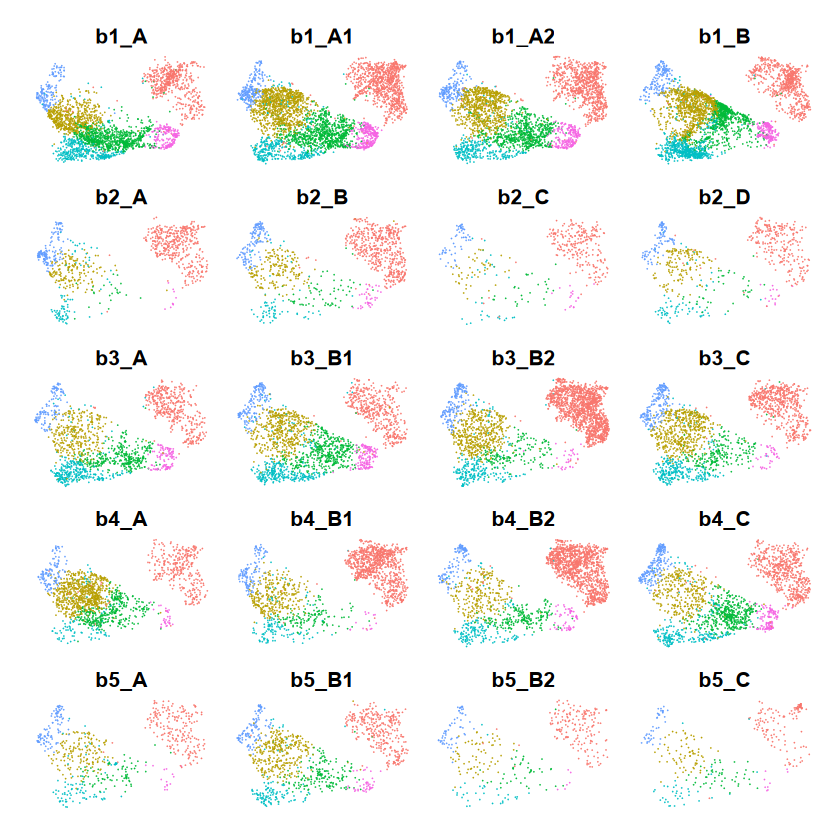

In [19]:
DimPlot(mac, split.by='orig.ident', label=F, ncol=4) + NoLegend() & NoAxes()

VlnPlot(mac, c('C1qc'), pt.size=0) &
    labs(x='', y='')
FeaturePlot(mac, c('C1qc'), pt.size=0.5) &
    NoLegend() & NoAxes()

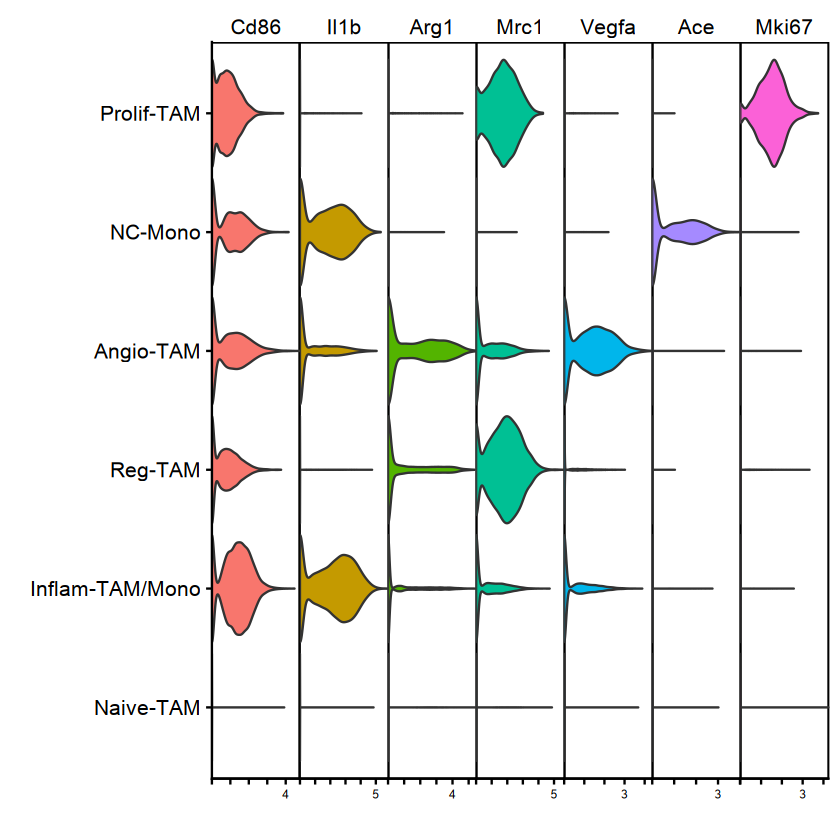

In [20]:
VlnPlot(mac, c('Cd86','Il1b','Arg1','Mrc1','Vegfa','Ace','Mki67'), pt.size=0, stack=T) &
    labs(x='', y='') & NoLegend() & theme(strip.text.x=element_text(face='plain', angle=0))
ggsave('plot/b16_violin_mac_markers.pdf', width=5, height=3.5, device=pdf)

In [21]:
markers_mac <- FindAllMarkers(mac, assay='RNA', only.pos=T, logfc.threshold=0.25)

Calculating cluster Naive-TAM

Calculating cluster Inflam-TAM/Mono

Calculating cluster Reg-TAM

Calculating cluster Angio-TAM

Calculating cluster NC-Mono

Calculating cluster Prolif-TAM



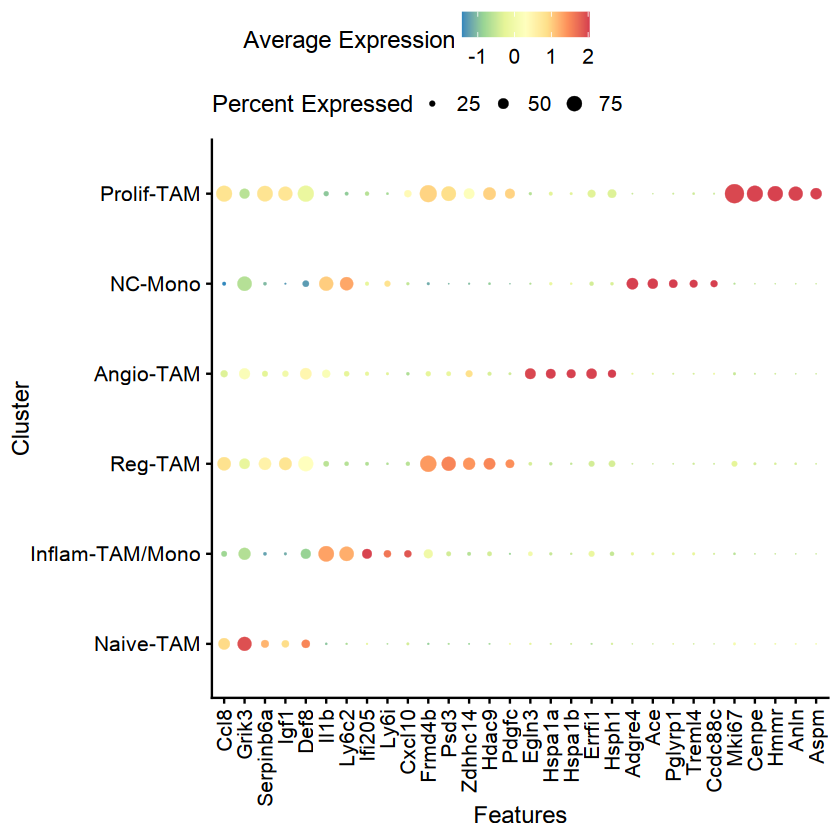

In [22]:
DotPlot(mac, features=markers_mac %>% filter(pct.1>0.3) %>% group_by(cluster) %>% top_n(5, wt=avg_log2FC) %>% pull(gene) %>% unique(), 
        dot.scale = 5, cols = 'Spectral') + labs(y='Cluster') + 
    theme(legend.position='top', axis.text.x=element_text(angle=90, hjust=1, vjust=0.5), legend.box='vertical')

ggsave('plot/b16_macrophage_marker_5batch.jpg', width=6.5, height=4, unit='in', dpi=200, bg='white', device=png)

In [23]:
write.csv(mac@meta.data,'data/b16_mac_meta.csv', quote=T)
saveRDS(mac, 'data/b16_mac.rds')

# Proportion analysis

`summarise()` has grouped output by 'annotation', 'sample', 'treatment', 'VLP', 'aCTLA4'. You can override using the `.groups`
argument.


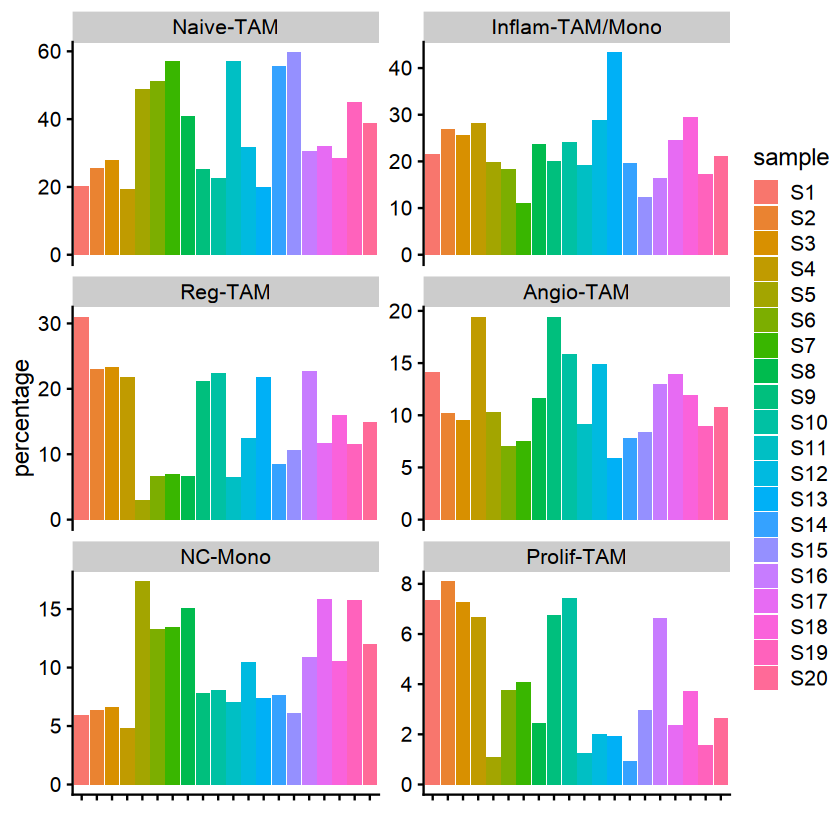

In [24]:
mac_percent_df <- mac@meta.data %>% group_by(annotation, sample, treatment, VLP, aCTLA4, batch) %>% summarise(count=n()) %>% 
    ungroup() %>% group_by(sample) %>% mutate(count_sample = sum(count)) %>% mutate(percentage = count/count_sample*100)%>%
    mutate(VLP=factor(VLP, levels=c('none','ID')), aCTLA4=factor(aCTLA4, levels=c('none','IV', 'ID')))
ggplot(mac_percent_df, aes(x=sample, y=percentage, fill=sample)) + geom_col() + 
    facet_wrap(~annotation, scales='free_y', ncol=2) + 
    theme_cowplot() + labs(x='',fill='sample') +
    theme_cowplot() + theme(legend.position='right', axis.text.x=element_blank())

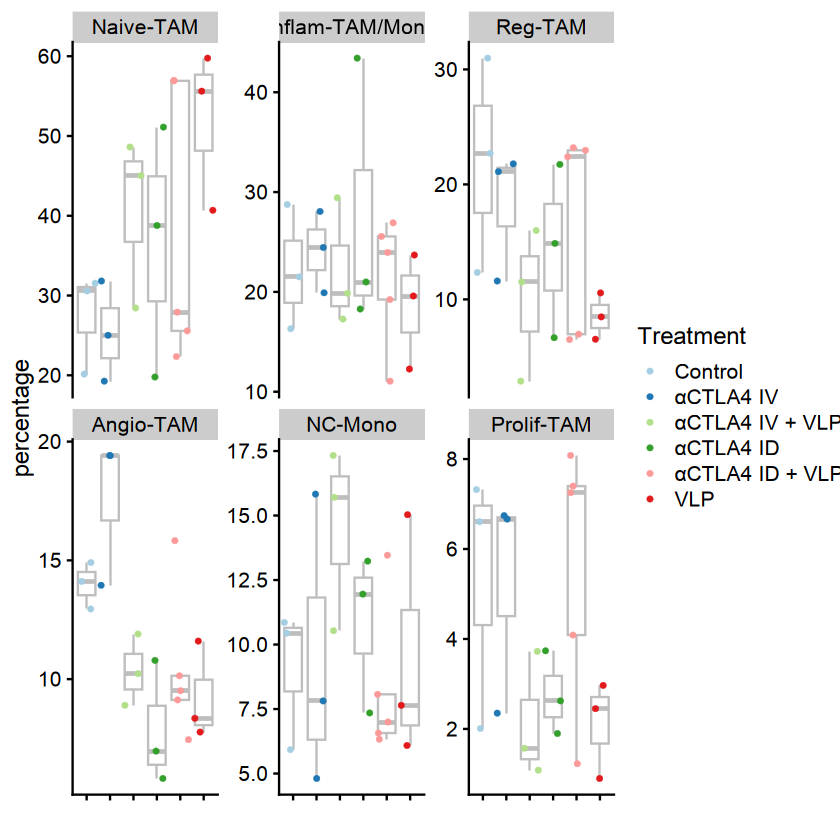

In [25]:
ggplot(mac_percent_df, aes(x=treatment, y=percentage, color=treatment)) + 
    geom_boxplot(color='gray', alpha=0.5, outliers=F) + 
    facet_wrap(~annotation, scales='free_y') + 
    theme_cowplot() + labs(x='',color='Treatment') + geom_jitter() +
    scale_color_brewer(palette='Paired') +
    theme(legend.position='right', axis.text.x=element_blank())
ggsave('plot/b16_macrophage_cluster_prop.png', width=7.5, height=3, unit='in', dpi=200, bg='white', device=png)

In [26]:
mac_percent_df %>% dplyr::select('sample','batch','VLP','aCTLA4','annotation','count') %>% 
    dcast(sample + batch + VLP + aCTLA4 ~ annotation) %>% write.csv('csv/b16_mac_cell_count.csv', row.names=F)

Using count as value column: use value.var to override.



In [27]:
dcast(mac_percent_df, annotation ~ sample, value.var='count')

annotation      S1  S2  S3  S4  S5  S6  S7  S8  S9  ⋯ S11  S12 S13 S14 S15 
1 Naive-TAM       534 905 816 633 404 506 237 249 397 ⋯ 1391 565 323 866 1188
2 Inflam-TAM/Mono 570 953 747 922 165 181  46 145 316 ⋯  470 515 709 305  244
3 Reg-TAM         821 813 678 716  24  66  29  40 335 ⋯  159 221 355 132  210
4 Angio-TAM       374 359 278 638  85  69  31  71 308 ⋯  223 267  95 121  166
5 NC-Mono         157 224 192 158 144 131  56  92 124 ⋯  171 187 120 119  121
6 Prolif-TAM      194 286 212 219   9  37  17  15 107 ⋯   30  36  31  14   59
  S16 S17 S18 S19 S20
1 583 203 313 172 133
2 311 156 324  66  72
3 433  74 176  44  51
4 247  89 131  34  37
5 207 101 116  60  41
6 126  15  41   6   9

pdf 
  2

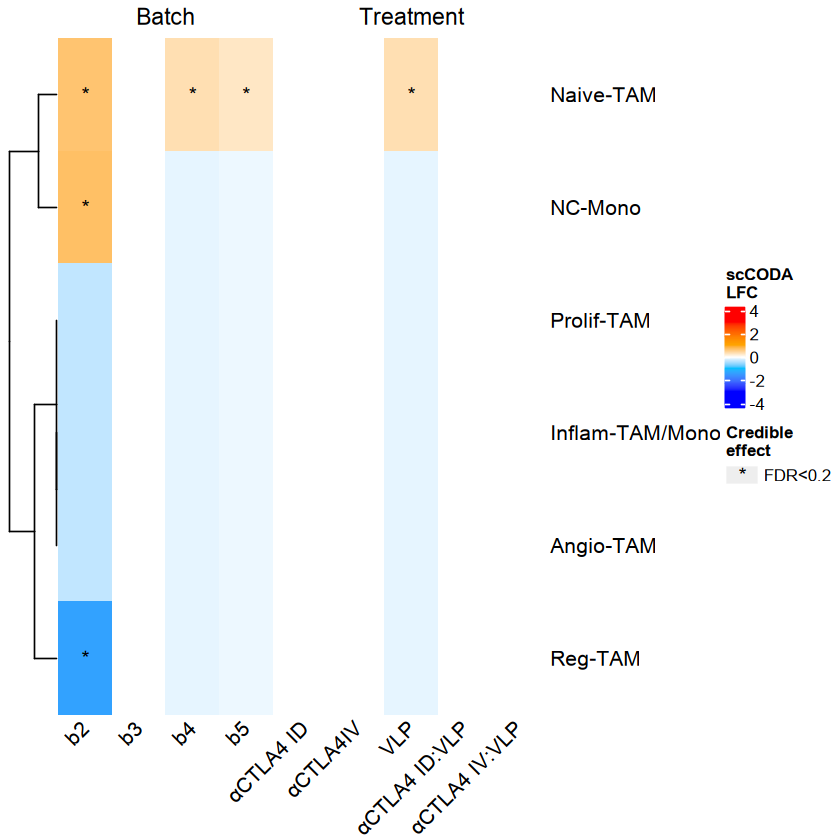

In [28]:
sccoda_df <- read.csv('csv/b16_mac_sccoda.csv')
lfc_mat <- sccoda_df %>% dcast(Cell.Type~ Covariate, value.var='log2.fold.change') %>% 
    column_to_rownames('Cell.Type') %>% as.matrix()
credible_mat <- sccoda_df %>% mutate(sig=ifelse(abs(Final.Parameter)>1e-10, '*', '')) %>% 
    dcast(Cell.Type~ Covariate, value.var='sig') %>% column_to_rownames('Cell.Type')
colnames(lfc_mat) <- c('b2','b3','b4','b5','αCTLA4 ID','αCTLA4IV','VLP','αCTLA4 ID:VLP','αCTLA4 IV:VLP')
lgd_sig <- Legend(title='Credible\neffect', pch = c('*'), type = "points", grid_width = unit(7, "mm"),
                  labels = c('FDR<0.2'))
ht <- Heatmap(lfc_mat, cluster_columns=F, name='scCODA\nLFC', col = colorRamp2(c(-3,-1,0,1,3),c('blue','deepskyblue','white','orange','red')),
       column_split = c(rep('Batch', 4),rep('Treatment', 5) ), column_names_rot = 45,
        cell_fun = function(j, i, x, y, w, h, col) { grid.text(credible_mat[i,j], x, y) })
draw(ht, annotation_legend_list = lgd_sig, legend_grouping = "original", merge_legend = TRUE)
cairo_pdf('plot/b16_mac_scCODA.pdf', width=5, height=3)
draw(ht, annotation_legend_list = lgd_sig, legend_grouping = "original", merge_legend = TRUE)
dev.off()

# Differential expression

In [29]:
seu$subtype <- as.character(seu$type)
seu@meta.data[rownames(mac@meta.data),'subtype'] <- as.character(mac$annotation)
apc <- subset(seu, subtype %in% c('Angio-TAM','Inflam-TAM/Mono','Naive-TAM','Prolif-TAM','Reg-TAM','NC-Mono','cDC1','cDC2','MigDC','pDC','B'))
apc

An object of class Seurat 
32285 features across 50826 samples within 1 assay 
Active assay: RNA (32285 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 3 dimensional reductions calculated: pca, harmony, umap

In [30]:
sum_exp_h2 <- rowSums(AverageExpression(apc, features=rownames(apc)[str_detect(rownames(apc), 'H2-')], assay='RNA')$RNA) 
sum_exp_h2[sum_exp_h2> 1]
high_exp_mhc <- c('H2-K1','H2-DMa','H2-DMb1','H2-DMb2','H2-Aa','H2-Ab1','H2-Eb1','H2-D1','B2m','H2-T23','H2-Q7')
class_mhc <- paste0('MHC-',c('I','II','II','II','II','II','II','I','I','I','I'))
names(class_mhc) <- high_exp_mhc

As of Seurat v5, we recommend using AggregateExpression to perform pseudo-bulk analysis.
This message is displayed once per session.


H2-K1     H2-Ke6      H2-Oa     H2-DMa    H2-DMb2    H2-DMb1      H2-Ob 
106.414168   2.580544   7.907960  29.726321  14.181084  24.236120   8.526374 
    H2-Ab1      H2-Aa     H2-Eb1     H2-Eb2      H2-D1      H2-Q4      H2-Q6 
252.829476 358.357075 265.162935   2.082012 134.707884   9.704053  10.314819 
     H2-Q7     H2-T23     H2-T22      H2-M3 
 19.165540  34.792909   7.712030   4.576062

In [31]:
deg_list <- list()
Idents(seu) <- 'type'
for(type_i in c('B','cDC1','cDC2','pDC','MigDC','Macro/Mono'))
{
    print(type_i)
    flush.console()
    for(group in c('αCTLA4 ID + VLP','αCTLA4 IV + VLP','VLP','αCTLA4 ID','αCTLA4 IV'))
    {
        if(sum(seu$treatment == group & seu$type == type_i)>3 & 
           sum(seu$treatment == 'Control' & seu$type == type_i)>3)
        {
            deg_list[[paste(type_i,group,'vs Control')]] <- FindMarkers(seu, subset.ident=type_i, min.pct=0.1, latent.vars='batch', test.use='MAST',
                       group.by='treatment', ident.1=group, ident.2='Control', logfc.threshold=0.01, features=high_exp_mhc) 
        }
    }
}

[1] "B"



 Completed [=======================================>----]  91% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

Warning message in .nextMethod(object = object, value = value):
“Coefficients batchb5 are never estimible and will be dropped.”

Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!


 Completed [============================================] 100% with 0 failures
                                                                              


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!




[1] "cDC1"



Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

Warning message in .nextMethod(object = object, value = value):
“Coefficients batchb5 are never estimible and will be dropped.”

Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "cDC2"



Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

Warning message in .nextMethod(object = object, value = value):
“Coefficients batchb5 are never estimible and will be dropped.”

Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "pDC"



Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

Warning message in .nextMethod(object = object, value = value):
“Coefficients batchb5 are never estimible and will be dropped.”

Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "MigDC"



Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

Warning message in .nextMethod(object = object, value = value):
“Coefficients batchb5 are never estimible and will be dropped.”

Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "Macro/Mono"



 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [=========================>------------------]  60% with 0 failures

 Completed [==============================>-------------]  70% with 0 failures

 Completed [==================================>---------]  80% with 0 failures

 Completed [=======================================>----]  90% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


 Completed [========>-----------------------------

In [32]:
Idents(mac) <- 'annotation'
annotation_i <- list('Naive-TAM'='Naive-TAM', 'Inflam-TAM/Mono'='Inflam-TAM/Mono', 'Reg-TAM'='Reg-TAM', 'Angio-TAM'='Angio-TAM',
                     'NC-Mono'='NC-Mono','Prolif-TAM'='Prolif-TAM',
                     'Macro/Mono'=c('Naive-TAM','Inflam-TAM/Mono','Reg-TAM','Angio-TAM','NC-Mono','Prolif-TAM'))
for(type_i in 'Macro/Mono')
{
    print(type_i)
    flush.console()
    suppressMessages({
        deg_list[[paste(type_i,'VLP ID vs none')]] <- FindMarkers(mac, subset.ident=annotation_i[[type_i]], latent.vars='batch', test.use='MAST',
                           group.by='VLP', ident.1='ID', ident.2='none', logfc.threshold=0.01, min.pct=0.1) 
        deg_list[[paste(type_i,'aCTLA4 ID vs none')]] <- FindMarkers(mac, subset.ident=annotation_i[[type_i]], latent.vars='batch', test.use='MAST',
                           group.by='aCTLA4', ident.1='ID', ident.2='none', logfc.threshold=0.01, min.pct=0.1) 
        deg_list[[paste(type_i,'aCTLA4 IV vs none')]] <- FindMarkers(mac, subset.ident=annotation_i[[type_i]], latent.vars='batch', test.use='MAST',
                           group.by='aCTLA4', ident.1='IV', ident.2='none', logfc.threshold=0.01, min.pct=0.1) 
    })
}
saveRDS(deg_list, 'data/b16_mac_deg_list.rds')

[1] "Macro/Mono"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.6 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.2 GiB”


In [33]:
for(type_i in c('Macro/Mono'))
{
    volcanos_type <- list()
    for(treat_i in c('VLP ID', 'aCTLA4 ID', 'aCTLA4 IV'))
    {
        deg_i <- deg_list[[paste(type_i,treat_i,'vs none')]] %>% rownames_to_column('gene') %>% 
            mutate(p.adj=ifelse(p_val_adj<0.05,'<0.05','>=0.05')) %>%
                         filter(!str_detect(gene, '^mt-|^Rpl|^Rps|^Hbb-'))
       volcano_i <- ggplot(deg_i, aes(x=avg_log2FC, y=-log10(p_val_adj))) + geom_point(aes(color=avg_log2FC)) +
            geom_hline(yintercept=-log10(0.05), linetype="dashed", color = "gray40") +
            geom_vline(xintercept=c(-0.5,0.5), linetype="dashed", color = "gray40") +
            geom_text_repel(data=deg_i %>% filter(p_val_adj<0.05 & abs(avg_log2FC)>0.5) , 
                    aes(label=gene), max.overlaps=10) +
            theme_cowplot() + theme(legend.position='none') + 
            scale_color_gradient2(low='blue',mid='gray',high='red') + 
            labs(x=paste('LFC'), y='-log10(p.adj)', title=paste(type_i,'(factor:',str_replace(treat_i,'a','α'),'vs none)')) +
            theme(plot.title=element_text(face='plain'))
        ggsave(paste0('plot/b16_volcano_',str_replace(type_i,'/','_'), '_',treat_i,'.pdf'), width=6, height=6, device=cairo_pdf)
        volcanos_type[[treat_i]] <- volcano_i
    }
    volcanos <- wrap_plots(volcanos_type, ncol=3)
    ggsave(paste0('plot/b16_volcano_',str_replace(type_i,'/','_'),'.pdf'), width=15, height=5, device=cairo_pdf)
}

Warning message:
“ggrepel: 45 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 93 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 273 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 64 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 100 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 286 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


Using treatment as id variables



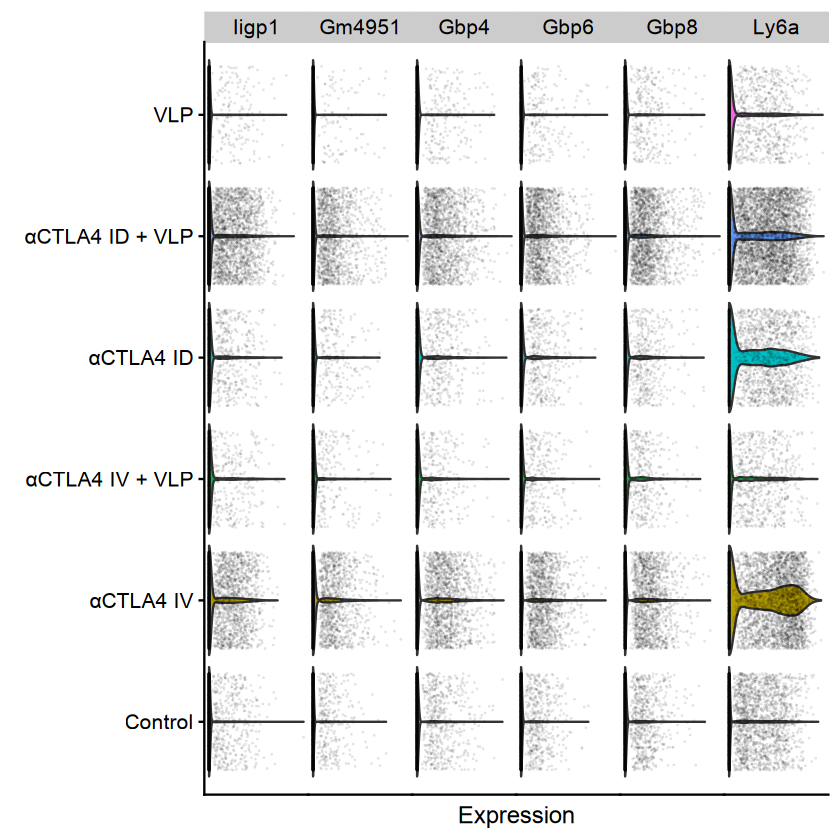

In [34]:
mac_top_degs <- FetchData(mac, c('Iigp1','Gm4951','Gbp4','Gbp6','Gbp8','Ly6a','treatment')) %>%
    melt(variable.name = 'gene', value.name='Expression')
ggplot(mac_top_degs, aes(y=treatment, x=Expression, fill=treatment)) + geom_violin(scale = 'width') + 
    geom_jitter(alpha=0.1, size=0.3) +
    facet_wrap(~gene, nrow=1, scales='free_x') + labs(y='') + theme_cowplot()  +
    theme(legend.position='none', panel.spacing = unit(0, "lines"), 
          axis.text.x=element_blank(), axis.ticks.x=element_blank()) #, strip.text.x = element_text(size = 9.5)

In [35]:
set.seed(0)
mac_gsea_df <- NULL
for(factor_i in c('VLP ID','aCTLA4 ID','aCTLA4 IV'))
{
    glist <- deg_list[[paste('Macro/Mono',factor_i,'vs none')]] %>% rownames_to_column('gene') %>% 
        filter(!str_detect(gene, '^mt-|^Rpl|^Rps|^Hbb-')) %>% 
            arrange(desc(avg_log2FC)) %>% 
            mutate(entrez = bitr(gene,'SYMBOL','ENTREZID', org.Mm.eg.db, drop=F)$ENTREZID) %>% 
            distinct(entrez, .keep_all=T) %>% pull(avg_log2FC, entrez)
    ego <- suppressWarnings(gseGO(glist, 'BP', org.Mm.eg.db)) %>% simplify() %>% setReadable(org.Mm.eg.db)
    df_factor_i <- data.frame(ego@result, 'treatment'=factor_i)
    mac_gsea_df <- rbind(mac_gsea_df, df_factor_i)
}
write.csv(mac_gsea_df, 'csv/b16_mac_gsea_df.csv', row.names=F)

'select()' returned 1:1 mapping between keys and columns

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `entrez = bitr(gene, "SYMBOL", "ENTREZID", org.Mm.eg.db, drop = F)$ENTREZID`.
Caused by warning in `bitr()`:
! 2.87% of input gene IDs are fail to map...”
using 'fgsea' for GSEA analysis, please cite Korotkevich et al (2019).


preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...

'select()' returned 1:1 mapping between keys and columns

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `entrez = bitr(gene, "SYMBOL", "ENTREZID", org.Mm.eg.db, drop = F)$ENTREZID`.
Caused by warning in `bitr()`:
! 2.84% of input gene IDs are fail to map...”
using 'fgsea' for GSEA analysis, please cite Korotkevich et al (2019).


preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...

'select()' returned 1:1 mapping between keys and columns

Warning message:
“There was 1 warning in `mutate()`.
ℹ In ar

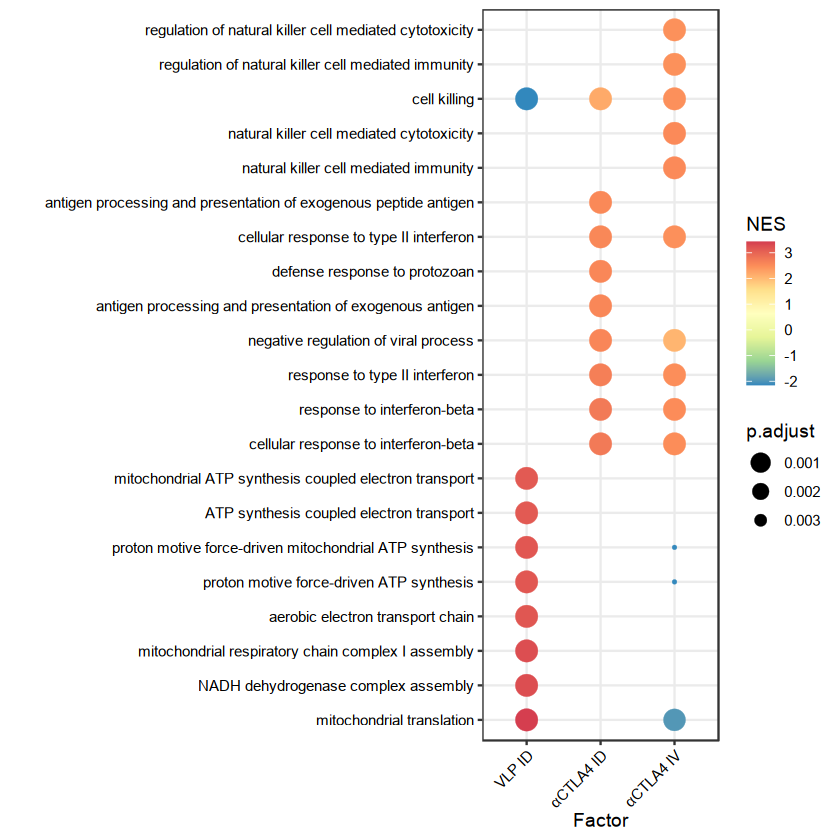

In [36]:
mac_gsea_df_top_term <- mac_gsea_df %>% group_by(treatment) %>% top_n(8, wt=NES) %>% pull(Description) %>% unique() 
ggplot(mac_gsea_df %>% filter(Description %in% mac_gsea_df_top_term) %>%
    mutate(treatment=str_replace(treatment, 'a', 'α')), aes(x=treatment, y=Description)) +
    geom_point(aes(size=p.adjust, color=NES)) + theme_bw() + scale_color_distiller(palette='Spectral') +
    scale_size(trans = 'reverse') + labs(x='Factor', y='') +
    scale_y_discrete(limits=mac_gsea_df_top_term) + theme(axis.text=element_text(color='black'), axis.text.x=element_text(angle=45, hjust=1, vjust=1))
ggsave('plot/b16_mac_gsea.pdf', width=6, height=6, device=cairo_pdf)

# Specific pathway enrichment

### GO terms of interest

GO:0019882 antigen processing and presentation

GO:0019884 antigen processing and presentation of exogenous antigen

GO:0048002 antigen processing and presentation of peptide antigen

GO:0002474 antigen processing and presentation of peptide antigen via MHC class I

GO:0002495 antigen processing and presentation of peptide antigen via MHC class II

GO:0002478 antigen processing and presentation of exogenous peptide antigen

GO:0042590 antigen processing and presentation of exogenous peptide antigen via MHC class I

GO:0002477 antigen processing and presentation of exogenous peptide antigen via MHC class Ib

GO:0019886 antigen processing and presentation of exogenous peptide antigen via MHC class II

GO:0002468 dendritic cell antigen processing and presentation

GO:0002450 B cell antigen processing and presentation

GO:0002472 macrophage antigen processing and presentation

GO:0034341 response to type II interferon

GO:0034340 response to type I interferon

GO:0001916 positive regulation of T cell mediated cytotoxicity

GO:0050870 positive regulation of T cell activation

In [37]:
app_list <- mapIds(org.Mm.eg.db, c('GO:0002474','GO:0002495',
                                   'GO:0034340','GO:0034341',
                                   'GO:0001916','GO:0050870'), "SYMBOL", "GOALL", multiVals = "list")

'select()' returned 1:many mapping between keys and columns



In [38]:
apc <- AddModuleScore_UCell(apc, features = app_list)
apc[["UCell"]] <- CreateAssayObject(counts = t(apc@meta.data[,str_detect(colnames(apc@meta.data), 'UCell')]))

Warning message:
“The following genes were not found and will be
                        imputed to exp=0:
* H2-Bl,H2-L,H2-T10,Raet1a,Raet1b,Raet1c,H2-Q8,H2-Q9,H2-T26,H2-T27,Marchf8,Marchf1,H2-Ea,Mx2,Oas1b,Smim30,Sting1,Eprs1,Gbp11,Gapdhrt2,Gapdh-ps15,Gapdhrt,Mir511,Cd1d2,Cyrib,Lilrb4b,Tcrb,Il36b,Mir326,Sirpd,Il4i1b”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [39]:
ucell_diff_list <- list()
Idents(apc) <- 'subtype'
DefaultAssay(apc) <- 'UCell'
for(type_i in unique(apc$subtype))
{
    print(type_i)
    flush.console()
    for(group in c('αCTLA4 IV','αCTLA4 IV + VLP','αCTLA4 ID','αCTLA4 ID + VLP','VLP'))
    {
        if(sum(apc$treatment == group & apc$subtype == type_i)>3 & 
           sum(apc$treatment == 'Control' & apc$subtype == type_i)>3)
        {
            ucell_diff_list[[paste(type_i,group,'vs Control')]] <- FindMarkers(apc, subset.ident=type_i, pseudocount.use=0,
                       group.by='treatment', ident.1=group, ident.2='Control', logfc.threshold=0) 
        }
    }
}
DefaultAssay(apc) <- 'RNA'

[1] "Angio-TAM"
[1] "Reg-TAM"
[1] "Naive-TAM"
[1] "Inflam-TAM/Mono"
[1] "cDC2"
[1] "MigDC"
[1] "NC-Mono"
[1] "Prolif-TAM"
[1] "B"
[1] "cDC1"
[1] "pDC"


In [40]:
GetDEGGroups <- function(deg_list, cell, groups=c('αCTLA4 IV','αCTLA4 IV + VLP','αCTLA4 ID','αCTLA4 ID + VLP','VLP'))
{
    merged_deg_df <- NULL
    for(group in groups)
    {
        deg_df <- rownames_to_column(deg_list[[paste(cell, group, 'vs Control')]], 'gene')
        deg_df$treatment <- group
        merged_deg_df <- rbind(merged_deg_df, deg_df)
    }
    return(merged_deg_df)
}
merged_app_df <- NULL
for(cell_i in c('Angio-TAM','Inflam-TAM/Mono','Naive-TAM','Prolif-TAM','Reg-TAM','NC-Mono','cDC1','cDC2','MigDC','pDC','B'))
{
    df_cell_i <- GetDEGGroups(ucell_diff_list, cell_i)
    df_cell_i$cell <- cell_i
    merged_app_df <- rbind(merged_app_df, df_cell_i)
}

pdf 
  2

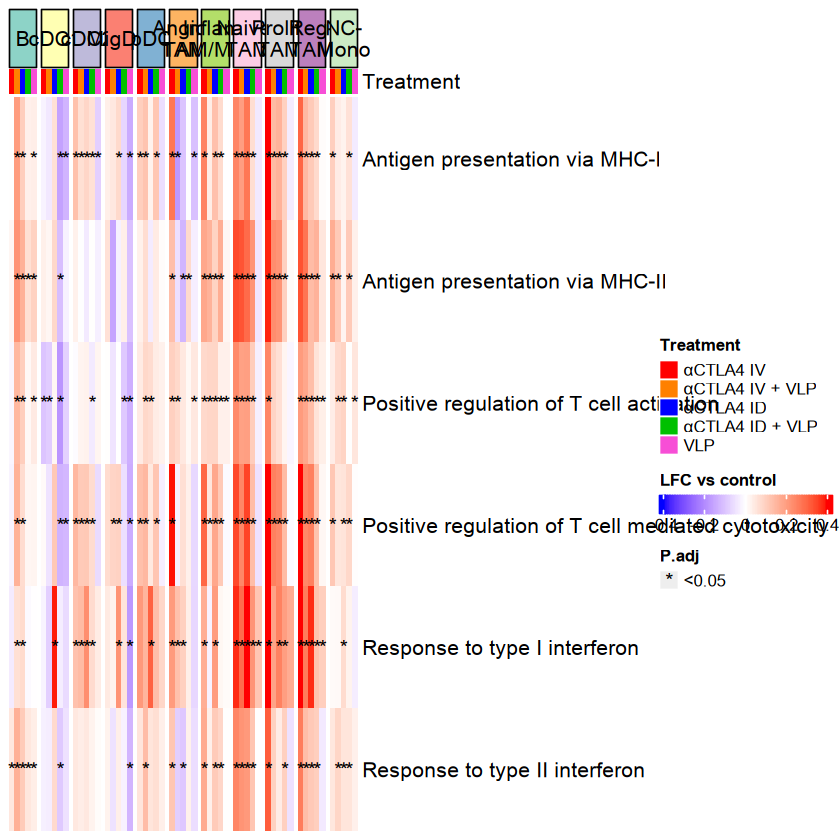

In [41]:
cluster_order <- c('B','cDC1','cDC2','MigDC','pDC','Angio-TAM','Inflam-TAM/Mono','Naive-TAM','Prolif-TAM','Reg-TAM','NC-Mono')
ucell_df <- merged_app_df %>% 
    mutate(treatment = factor(treatment, levels=c('αCTLA4 IV','αCTLA4 IV + VLP','αCTLA4 ID','αCTLA4 ID + VLP','VLP')),
           terms=recode(gene, 'GO:0002474-UCell'='Antigen presentation via MHC-I',
                              'GO:0002495-UCell'='Antigen presentation via MHC-II',
                              'GO:0001916-UCell'='Positive regulation of T cell mediated cytotoxicity',
                              'GO:0050870-UCell'='Positive regulation of T cell activation',
                              'GO:0034340-UCell'='Response to type I interferon',
                              'GO:0034341-UCell'='Response to type II interferon'))
fc_ucell <- ucell_df %>% dcast(cell+treatment~terms, value.var='avg_log2FC') %>% 
    mutate(cell=factor(str_replace(cell,'-','-\n'), levels=str_replace(cluster_order,'-','-\n')))
sig_ucell <- ucell_df %>% dcast(cell+treatment~terms, value.var='p_val_adj') %>% 
    mutate(cell=factor(cell, levels=cluster_order)) %>% .[,-c(1:2)] %>% mutate_all(~ifelse(.x <0.05, '*', '')) %>% t()
ht_cols <- c(brewer.pal(11, 'Set3'), c('red','#FF8000','blue','#00C000','#F74ED6'))#[c(7:12,1:3,5:6)]
names(ht_cols) <- c(unique(fc_ucell$cell),as.character(unique(fc_ucell$treatment)))
col_ha <- HeatmapAnnotation('Cluster'=anno_block(labels=as.character(levels(fc_ucell$cell)), gp = gpar(fill = ht_cols[1:11])),
                            'Treatment'=fc_ucell$treatment, col=list(Treatment=ht_cols[12:16]), height=unit(0.7,'in'))
ht <- Heatmap(t(fc_ucell[,-(1:2)]), name='LFC vs control', cluster_columns = F, cluster_rows = F, 
              col = colorRamp2(c(-0.4,0,0.4),c('blue','white','red')),
              column_split=fc_ucell$cell, column_title=NULL,
              heatmap_legend_param = list(direction = "horizontal"), top_annotation = col_ha, 
        cell_fun = function(j, i, x, y, w, h, col) { grid.text(sig_ucell[i, j], x, y)})#
lgd_sig_deg <- Legend(title='P.adj', pch = c('*'), type = "points",  labels = c('<0.05'))
ComplexHeatmap::draw(ht, merge_legend = TRUE, annotation_legend_list = lgd_sig_deg)
cairo_pdf('plot/heatmap_ucell_treatment.pdf', width=14, height=2.2)
ComplexHeatmap::draw(ht, merge_legend = TRUE, annotation_legend_list = lgd_sig_deg)
dev.off()

pdf 
  2

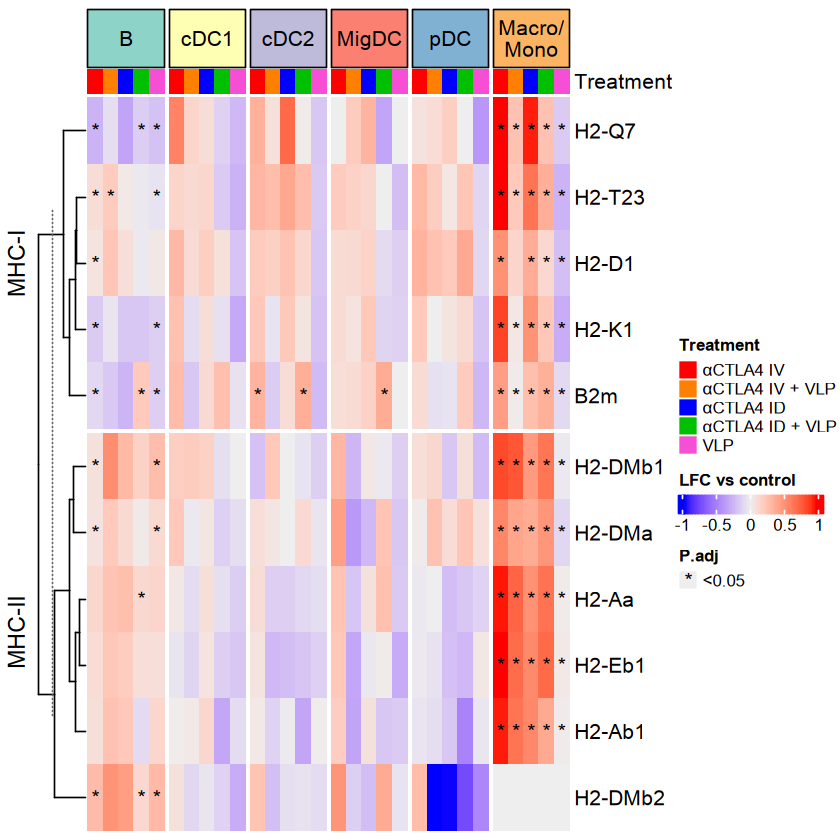

In [42]:
mhc_deg <- bind_rows(lapply(deg_list[str_detect(names(deg_list), '(Macro|DC|B)') & str_detect(names(deg_list), 'Control')], 
      function(x) x %>% rownames_to_column('gene') %>% filter(gene %in% high_exp_mhc)), .id='compare')
mhc_deg <- mhc_deg %>% 
    mutate(cell=str_replace(str_extract(compare, '^[^ ]*(?= )'),'/','/\n'), cell=factor(cell, levels=c('B','cDC1','cDC2','MigDC','pDC','Macro/\nMono')),
           sample=str_replace(str_extract(compare, '(?<= ).*$'),' vs Control',''),
          sample=factor(sample, levels=c('αCTLA4 IV','αCTLA4 IV + VLP','αCTLA4 ID','αCTLA4 ID + VLP','VLP'))) %>%
    arrange(gene, cell, sample)
fc_mhc <- mhc_deg %>% 
    dplyr::select(gene, cell, sample, avg_log2FC) %>% pivot_wider(names_from = gene, values_from=avg_log2FC)
fc_mhc[is.na(fc_mhc)] <- 0
p_mhc <- mhc_deg  %>% 
    dplyr::select(gene, cell, sample, p_val_adj) %>% pivot_wider(names_from = gene, values_from=p_val_adj)
p_mhc[is.na(p_mhc)] <- 1
sig_mhc <- p_mhc[,-(1:2)] %>% mutate_all(~ifelse(.x <0.05, '*', '')) %>% t()
ht_cols <- c(brewer.pal(6, 'Set3'), c('red','#FF8000','blue','#00C000','#F74ED6'))
names(ht_cols) <- c(unique(fc_mhc$cell),levels(fc_mhc$sample))
col_ha <- HeatmapAnnotation('Cluster'=anno_block(labels=levels(mhc_deg$cell), gp = gpar(fill = ht_cols[1:6])),
                            'Treatment'=fc_mhc$sample, col=list(Treatment=ht_cols[7:11]), height=unit(0.7,'in')) 
ht <- Heatmap(t(fc_mhc[,-(1:2)]), name='LFC vs control', cluster_columns = F, 
                row_split=class_mhc[colnames(fc_mhc[,-(1:2)])], column_split=fc_mhc$cell, column_title=NULL,
              heatmap_legend_param = list(direction = "horizontal"),
        top_annotation = col_ha, cell_fun = function(j, i, x, y, w, h, col) { grid.text(sig_mhc[i, j], x, y)})
lgd_sig_deg <- Legend(title='P.adj', pch = c('*'), type = "points",  labels = c('<0.05'))
ComplexHeatmap::draw(ht, merge_legend = TRUE, annotation_legend_list = lgd_sig_deg)
cairo_pdf('plot/heatmap_mhc_exp_treatment.pdf', width=8, height=2.8)
ComplexHeatmap::draw(ht, merge_legend = TRUE, annotation_legend_list = lgd_sig_deg)
dev.off()